# Getting Started

**Zhenwen Dai (2018.10.22)**

```
# Copyright 2018 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
#   Licensed under the Apache License, Version 2.0 (the "License").
#   You may not use this file except in compliance with the License.
#   A copy of the License is located at
#
#       http://www.apache.org/licenses/LICENSE-2.0
#
#   or in the "license" file accompanying this file. This file is distributed
#   on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either
#   express or implied. See the License for the specific language governing
#   permissions and limitations under the License.
# ==============================================================================
```

## Introduction

MXFusion is a probabilistic programming language. It provides a convenient interface for designing probabilistic models and applying them to real world problems.

Probabilistic models describe the relationships in data through probabilistic distributions of random variables. Probabilistic modeling is typically done by stating your prior belief about the data in terms of a probabilistic model and performing inference with the observations of some of the random variables.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['MXNET_ENGINE_TYPE'] = 'NaiveEngine'

## A Simple Example

Let's start with a toy example about estimating the mean and variance of a set of data. For simplicity, we generate 100 data points with a given mean and variance following a normal distribution.

In [2]:
import numpy as np
np.random.seed(0)
mean_groundtruth = 3.
variance_groundtruth = 5.
N = 100
data = np.random.randn(N)*np.sqrt(variance_groundtruth) + mean_groundtruth

Let's visualize our data by building a histogram.

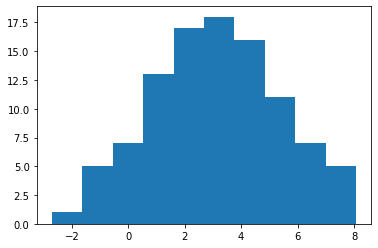

In [3]:
%matplotlib inline
from pylab import *
_=hist(data, 10)

Now, let's pretend that we do not know the mean and variance that are used to generate the above data. 

We still believe that the data come from a normal distribution, which is our model. It is formulated as
$$y_n \sim \mathcal{N}(\mu, s), \quad Y=(y_1, \ldots, y_{100})$$
where $\mu$ is the mean, $s$ is the variance and $Y$ is the vector representing the data.


In MXFusion, the above model can be defined as follows:

In [4]:
from mxfusion import Variable, Model
from mxfusion.components.variables import PositiveTransformation
from mxfusion.components.distributions import Normal
from mxfusion.common import config
config.DEFAULT_DTYPE = 'float64'

m = Model()
m.mu = Variable()
m.s = Variable(transformation=PositiveTransformation())
m.Y = Normal.define_variable(mean=m.mu, variance=m.s, shape=(N,))

In the above definition, we start with defining a model by instantiated from the class <tt>Model</tt>. The variable $\mu$ and $s$ are created from the class <tt>Variable</tt>. Both of them are assigned as members of the model instance <tt>m</tt>. This is how variables are organized in MXFusion. The variable <tt>s</tt> is created by passing a <tt>PositiveTransformation</tt> instance to the <tt>transforamtion</tt> argument. This constrains the value of the variable <tt>s</tt> to be positive through a "soft-plus" transformation. The variable <tt>Y</tt> is created from a normal distribution by specifying the mean and variance and its shape. 

Note that, in this example, the mean and variance variable are both scalar, with the shape (1,), while the random variable <tt>Y</tt> has the shape (100,). This indicates the mean and variance variable are broadcasted into the shape of the random variable, just like the broadcasting rule in numpy array operation. In this case, this means the individual entries of the random variable <tt>Y</tt> follows a scalar normal distribution with the same mean and variance.

To list the content that is defined in the model instance, just print the model instance as follows:

In [5]:
print(m)

Model (637b9)
Variable Y (e2721) ~ Normal(mean=Variable mu (3f2b3), variance=Variable s (cddb2))


After defining the probabilistic model, we want to estimate the mean and variance of the normal distribution in our model conditioned on the data that we generated. In MXFusion, this is done by creating an inference algorithm and passing it into the creation of an <tt>Inference</tt> instance. An inference algorithm represents a specific algorithm for a probabilistic inference. In this example, we performs a maximum likelihood estimate by using the <tt>MAP</tt> class. The <tt>Inference</tt> class takes care of the initialization of parameters and the execution of inference.

In the following code, we created a <tt>MAP</tt> inference algorithm by specifying the model and the set of observed variable. Then, we created a <tt>GradBasedInference</tt> instance from the instantiated <tt>MAP</tt> infernece algorithm.

The execution of inference is done by calling the <tt>call</tt> function. The <tt>call</tt> function takes all observed data (specified when creating the inference algorithm) as the keyword arguments, where the keys are the names of the member variables of the model and the values are the corresponding MXNet NDArrays. In this example, we only observed the variable <tt>Y</tt>, then, we pass "Y" as the key and the generated data as the value. We also specify the configuration parameters for the gradient optimizer such as the learning rate, the maximum number of iterations and whether to print the optimization progress. The default optimizer is adam.

In [6]:
from mxfusion.inference import GradBasedInference, MAP
import mxnet as mx

infr = GradBasedInference(inference_algorithm=MAP(model=m, observed=[m.Y]))
infr.run(Y=mx.nd.array(data, dtype='float64'), learning_rate=0.1, max_iter=2000, verbose=True)

Iteration 200 loss: 226.030				
Iteration 400 loss: 223.629				
Iteration 600 loss: 223.232				
Iteration 800 loss: 223.163				
Iteration 1000 loss: 223.152				
Iteration 1200 loss: 223.151				
Iteration 1400 loss: 223.151				
Iteration 1600 loss: 223.151				
Iteration 1800 loss: 223.151				
Iteration 2000 loss: 223.151				


After optimization, the estimated parameters are stored in an instance of the class <tt>InferenceParameters</tt>, which can be access from an <tt>Inference</tt> instance by <tt>infr.params</tt>.

We collect the estimated mean and variance and compared with the generating parameters.

In [7]:
mean_estimated = infr.params[m.mu].asnumpy()
variance_estimated = infr.params[m.s].asnumpy()

print('The estimated mean and variance: %f, %f.' % (mean_estimated, variance_estimated))
print('The true mean and variance: %f, %f.' % (mean_groundtruth, variance_groundtruth))

The estimated mean and variance: 3.133735, 5.079126.
The true mean and variance: 3.000000, 5.000000.


The estimated parameters are close to the generating parameters, but still off by a small amount. This difference is due to the small size of dataset we used, a problem known as *over-fitting*.

## A Bayesian model

From the above example, we have done a maximum likelihood estimate from the observed data. Due to the limited number of data, the estimated parameters are not the same as the true parameters. An interesting question here is that whether we can have an estimate about how big the difference is. One approach to provide such an estimate is via Bayesian inference. 

Following the above example, we need to assume prior distributions for the mean and variance of the normal distribution. We assume the mean to be a normal distribution with a relative big variance, indicating that we do not have much knowledge about the parameter.

In [8]:
m = Model()
m.mu = Normal.define_variable(mean=mx.nd.array([0], dtype='float64'), 
                              variance=mx.nd.array([100], dtype='float64'), shape=(1,))

Then, we need to specify a prior distribution for the variance. This is a bit more complicated as the variance needs to be positive. In principle, one can use a distribution of positive values such as the Gamma distribution. To enable inference with the reparameterization trick, we, instead, assume a random variable $\hat{s}$ with a normal distribution and the variance $s$ is a function of $\hat{s}$,
$$
\hat{s} \sim \mathcal{N}(5, 100), \quad s = \log(1+e^{\hat{s}}).
$$
The above function is often referred to as the "soft-plus" function, which transforms a real number to a positive number. By applying the transformation, we indirectly specifies the prior distribution for the variance. 

To implement the above prior in MXFusion, we first create the variable <tt>s_hat</tt> with a normal distribution. Then, we defines a function in the MXNet Gluon syntax, which is also called a Gluon block, for the "soft-plus" transformation. The MXNet function is brought into the MXFusion environment by applying a wrapper called <tt>MXFusionGluonFunction</tt>, in which we specify the number of outputs. We pass the variable <tt>s_hat</tt> as the input to the function and get the variable <tt>s</tt> as the return value.

In [9]:
from mxfusion.components.functions import MXFusionGluonFunction

m.s_hat = Normal.define_variable(mean=mx.nd.array([5], dtype='float64'), 
                                 variance=mx.nd.array([100], dtype='float64'),
                                 shape=(1,), dtype='float64')
trans_mxnet = mx.gluon.nn.HybridLambda(lambda F, x: F.Activation(x, act_type='softrelu'))
m.trans = MXFusionGluonFunction(trans_mxnet, num_outputs=1, broadcastable=True)
m.s = m.trans(m.s_hat)

We define the variable <tt>Y</tt> following a normal distribution with the mean <tt>mu</tt> and the variance <tt>s</tt>. 

In [10]:
m.Y = Normal.define_variable(mean=m.mu, variance=m.s, shape=(N,), dtype='float64')
print(m)

Model (e2f16)
Variable s_hat (459a5) ~ Normal(mean=Variable (f8b0f), variance=Variable (343b3))
Variable s (b43d3) = GluonFunctionEvaluation(hybridlambda0_input_0=Variable s_hat (459a5))
Variable mu (62f33) ~ Normal(mean=Variable (9057c), variance=Variable (03688))
Variable Y (9d22c) ~ Normal(mean=Variable mu (62f33), variance=Variable s (b43d3))


Inference for the above model is more complex, as the exact inference is intractable. We use variational inference with a Gaussian mean field posterior. 

We construct the variational posterior by calling the function <tt>create_Gaussian_meanfield</tt>, which defines a Gaussian distribution for both the mean and the variance as the variational posterior. The content in the generated posterior can be listed by printing the posterior.

In [11]:
from mxfusion.inference import create_Gaussian_meanfield

q = create_Gaussian_meanfield(model=m, observed=[m.Y])
print(q)

Posterior (42f50)
Variable s_hat (459a5) ~ Normal(mean=Variable (a44d5), variance=Variable (a74ce))
Variable mu (62f33) ~ Normal(mean=Variable (286b2), variance=Variable (57f6f))


Then, we created an instance of <tt>StochasticVariationalInference</tt> with both the model and the variational posterior. We also need to specify the number of samples used in inference, as it uses the Monte Carlo method for approximating the integral in the variational lower bound. The execution of inference follows the same interface.

In [12]:
from mxfusion.inference import StochasticVariationalInference

infr = GradBasedInference(inference_algorithm=StochasticVariationalInference(
    model=m, posterior=q, num_samples=10, observed=[m.Y]))
infr.run(Y=mx.nd.array(data, dtype='float64'), learning_rate=0.1, verbose=True)

Iteration 200 loss: 235.140				
Iteration 400 loss: 231.011				
Iteration 600 loss: 229.947				
Iteration 800 loss: 229.648				
Iteration 1000 loss: 229.859				
Iteration 1200 loss: 229.752				
Iteration 1400 loss: 229.651				
Iteration 1600 loss: 229.705				
Iteration 1800 loss: 229.634				
Iteration 2000 loss: 229.641				


Let's check the resulting posterior distribution.

In [13]:
mu_mean = infr.params[q.mu.factor.mean].asscalar()
mu_std = np.sqrt(infr.params[q.mu.factor.variance].asscalar())
s_hat_mean = infr.params[q.s_hat.factor.mean].asscalar()
s_hat_std = np.sqrt(infr.params[q.s_hat.factor.variance].asscalar())
s_15 = np.log1p(np.exp(s_hat_mean - s_hat_std))
s_50 = np.log1p(np.exp(s_hat_mean))
s_85 = np.log1p(np.exp(s_hat_mean + s_hat_std))
print('The mean and standard deviation of the mean parameter is %f(%f). ' % (mu_mean, mu_std))
print('The 15th, 50th and 85th percentile of the variance parameter is %f, %f and %f.'%(s_15, s_50, s_85))

The mean and standard deviation of the mean parameter is 3.120117(0.221690). 
The 15th, 50th and 85th percentile of the variance parameter is 4.604521, 5.309114 and 6.016289.


The true parameter sits within one standard deviation of the estimated posterior distribution for both the mean and variance parameters. The above error gives a good indication about how much we could trust the parameters that we estimate.